## 官方keras訓練集的格式

In [1]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets_fix(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
        return x, y

### 顯示line:28~32在做什麼

# 預計修改的東西

In [2]:
import os
import numpy as np
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image
from PIL import ImageOps
input_dir = "D:\\FoodSeg103\\FoodSeg103\\Images\\img_dir\\train"
target_dir = "D:\\FoodSeg103\\FoodSeg103\\Images\\ann_dir\\train"

img_size = (160, 160)
num_classes = 104
batch_size = 2

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 4983
D:\FoodSeg103\FoodSeg103\Images\img_dir\train\00000000.jpg | D:\FoodSeg103\FoodSeg103\Images\ann_dir\train\00000000.png
D:\FoodSeg103\FoodSeg103\Images\img_dir\train\00000001.jpg | D:\FoodSeg103\FoodSeg103\Images\ann_dir\train\00000001.png
D:\FoodSeg103\FoodSeg103\Images\img_dir\train\00000002.jpg | D:\FoodSeg103\FoodSeg103\Images\ann_dir\train\00000002.png
D:\FoodSeg103\FoodSeg103\Images\img_dir\train\00000003.jpg | D:\FoodSeg103\FoodSeg103\Images\ann_dir\train\00000003.png
D:\FoodSeg103\FoodSeg103\Images\img_dir\train\00000004.jpg | D:\FoodSeg103\FoodSeg103\Images\ann_dir\train\00000004.png
D:\FoodSeg103\FoodSeg103\Images\img_dir\train\00000005.jpg | D:\FoodSeg103\FoodSeg103\Images\ann_dir\train\00000005.png
D:\FoodSeg103\FoodSeg103\Images\img_dir\train\00000006.jpg | D:\FoodSeg103\FoodSeg103\Images\ann_dir\train\00000006.png
D:\FoodSeg103\FoodSeg103\Images\img_dir\train\00000007.jpg | D:\FoodSeg103\FoodSeg103\Images\ann_dir\train\00000007.png
D:\FoodSeg103\Fo

In [3]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=(160,160,3))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer


#     outputs = layers.Conv2D(3, kernel_size=1, strides=1, activation="sigmoid", padding="same")(x)
#     outputs = layers.Conv2D(num_classes, 2, activation="sigmoid", padding="same")(x)
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)
    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [4]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets_fix(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets_fix(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [5]:
#GPu memory 會暫滿，需要重啟
#把h5文件存下來，下次預測的時候再input進來
#IOU ， learning rate ，
import tensorflow as tf
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
# model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
# "binary_crossentropy"
# model.compile(optimizer=tf.keras.optimizers.Adam(
#     learning_rate=10e-6), loss=[focal_loss(alpha=.25, gamma=2)])
model.compile(optimizer=tf.keras.optimizers.Adam(
     learning_rate=0.0001), 
        loss=["binary_crossentropy"]
)

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation_fix_v8.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 10
training = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/10
  38/1991 [..............................] - ETA: 3:14 - loss: -292.9740

KeyboardInterrupt: 

## load 訓練好的model

In [1]:
import os
import numpy as np
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image
from PIL import ImageOps
input_dir = "D:\\FoodSeg103\\FoodSeg103\\Images\\img_dir\\train"
target_dir = "D:\\FoodSeg103\\FoodSeg103\\Images\\ann_dir\\train"

img_size = (64, 64)
num_classes = 104
batch_size = 2

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 4983
D:\FoodSeg103\FoodSeg103\Images\img_dir\train\00000000.jpg | D:\FoodSeg103\FoodSeg103\Images\ann_dir\train\00000000.png
D:\FoodSeg103\FoodSeg103\Images\img_dir\train\00000001.jpg | D:\FoodSeg103\FoodSeg103\Images\ann_dir\train\00000001.png
D:\FoodSeg103\FoodSeg103\Images\img_dir\train\00000002.jpg | D:\FoodSeg103\FoodSeg103\Images\ann_dir\train\00000002.png
D:\FoodSeg103\FoodSeg103\Images\img_dir\train\00000003.jpg | D:\FoodSeg103\FoodSeg103\Images\ann_dir\train\00000003.png
D:\FoodSeg103\FoodSeg103\Images\img_dir\train\00000004.jpg | D:\FoodSeg103\FoodSeg103\Images\ann_dir\train\00000004.png
D:\FoodSeg103\FoodSeg103\Images\img_dir\train\00000005.jpg | D:\FoodSeg103\FoodSeg103\Images\ann_dir\train\00000005.png
D:\FoodSeg103\FoodSeg103\Images\img_dir\train\00000006.jpg | D:\FoodSeg103\FoodSeg103\Images\ann_dir\train\00000006.png
D:\FoodSeg103\FoodSeg103\Images\img_dir\train\00000007.jpg | D:\FoodSeg103\FoodSeg103\Images\ann_dir\train\00000007.png
D:\FoodSeg103\Fo

In [6]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets_fix(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (104,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            img_array = np.array(img)
            for z in np.unique(img_array):
                if z ==0:
                    continue
                label_mask = np.where(img_array==z,1,0)
                y[j,:,:,z] = label_mask  
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
        return x, y

In [11]:
len(train_input_img_paths[0:32])

32

In [12]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets_fix(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets_fix(batch_size, img_size, val_input_img_paths, val_target_img_paths)
test_train_gen =  OxfordPets_fix(
    batch_size, img_size, train_input_img_paths[0:32], train_target_img_paths[0:32]
)

In [13]:
import tensorflow as tf
from tensorflow import keras
model = keras.models.load_model("oxford_segmentation_fix_v6.h5")


In [83]:
val_preds[1].shape


(64, 64, 104)

In [14]:
# Generate predictions for all images in the validation set

val_gen = OxfordPets_fix(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(test_train_gen)

# val_preds = (val_preds > 0.5).astype(np.uint8)

def display_mask(i):
    """Quick utility to display a model's prediction."""
    print()
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 5

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(3)  # Note that the model only sees inputs at 150x150.

TypeError: 'module' object is not callable

In [15]:
def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    plt.imshow(mask[:,:,1])
    print(mask.shape)
    print(mask[:,:,0])
    print(np.unique(mask))
#     img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
#     display(img)

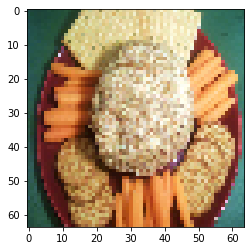

In [24]:
i =0
img_o = load_img(train_input_img_paths[i], target_size=img_size)
plt.imshow(img_o)

<PIL.Image.Image image mode=L size=64x64 at 0x20D002D7250>
[ 0  5 58 84]


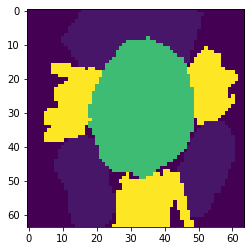

In [25]:

img = load_img(train_target_img_paths[i], target_size=img_size, color_mode="grayscale")
plt.imshow(img)
print(img)
print(np.unique(np.array(img)))

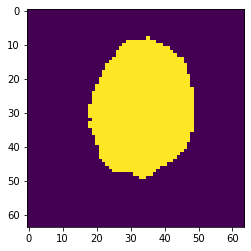

In [46]:
img = load_img(train_target_img_paths[i], target_size=img_size, color_mode="grayscale")
img_array = np.array(img)
img_array_mask = np.where(img_array==58,1,0)
img_array_mask.shape
plt.imshow(img_array_mask)

In [264]:
np.percentile(test_mask, 99)

0.023371145036071562

(64, 64, 104)
-----------
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[5.1299709e-10 1.1012147e-09 1.1048692e-09 ... 6.0297000e-01 6.0440373e-01
 6.0716796e-01]


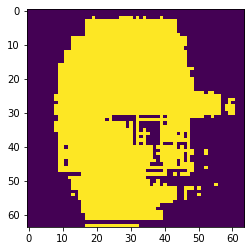

In [51]:
test = val_preds[i]
test_mask = test[:,:,58]
test_threshold = np.where(test_mask > np.percentile(test_mask,50),1,0)
# test_threshold = np.where(test_mask ,test_mask,0)
print(test.shape)
print("-----------")
print(test_threshold)
print(np.unique(test))
plt.imshow(test_threshold)
# test[:,:,47].shape

(64, 64, 1)
[[58 58 58 ... 58 58 58]
 [58 87 87 ... 58 58 58]
 [87 87 87 ... 58 58 58]
 ...
 [87 87 87 ... 87 87 87]
 [87 87 87 ... 87 87 87]
 [87 87 87 ... 87 87 87]]
[ 5 10 25 32 37 41 46 47 48 50 51 58 59 73 80 82 84 87 89 93 94 95 96]


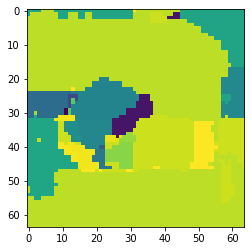

In [88]:
display_mask(4)

<PIL.Image.Image image mode=RGB size=810x1080 at 0x20C8F02E2B0>
[ 0  8 48 88]


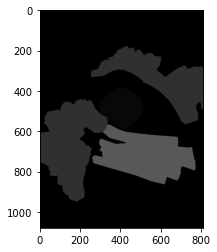

In [17]:
import os
import numpy as np
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image
from PIL import ImageOps
import matplotlib.pyplot as plt
i =4
img = load_img(val_target_img_paths[i])
plt.imshow(img)
print(img)
print(np.unique(np.array(img)))

(64, 64, 1)
[[[ 41]
  [ 59]
  [  5]
  ...
  [ 82]
  [ 44]
  [ 44]]

 [[ 54]
  [ 59]
  [ 66]
  ...
  [ 53]
  [ 53]
  [ 73]]

 [[ 54]
  [ 59]
  [ 84]
  ...
  [ 64]
  [ 53]
  [ 73]]

 ...

 [[103]
  [ 38]
  [ 87]
  ...
  [ 61]
  [ 68]
  [ 21]]

 [[103]
  [ 59]
  [ 87]
  ...
  [ 87]
  [ 68]
  [ 21]]

 [[ 89]
  [ 37]
  [ 37]
  ...
  [ 62]
  [ 62]
  [ 21]]]


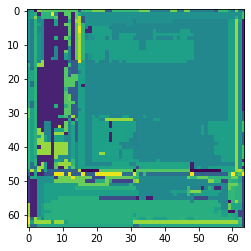

In [60]:
display_mask(i)

In [11]:
import tensorflow as tf
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.5)

session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [ ]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5) 
config = tf.ConfigProto(gpu_options=gpu_options) 
config.gpu_options.allow_growth = True 
session = tf.Session(config=config) 

In [9]:
from socket import socket